# 4개 모델 성능 비교
```
4개 모델 성능 비교표
        
    모델	Accuracy	Recall (flood=1)	ROC AUC
RandomForest	0.9811	         0.8000	                0.9843
XGBoost     	0.9641	         0.8765              	0.9775
LSTM+CNN	0.5873	         0.8642              	0.7688
Transformer	0.7299	         0.6790              	0.7812

해석 요약
RandomForest: 전체적으로 가장 안정적. Accuracy, Recall, ROC AUC 모두 우수.

XGBoost: 침수 예측(Recall)에 가장 뛰어남. 성능 균형 좋음.

LSTM+CNN: Accuracy는 낮지만 Recall은 높아, 침수 감지엔 민감한 편.

Transformer: Recall은 나쁘지 않지만 Precision이 낮고 전체 정확도도 낮은 편.
```

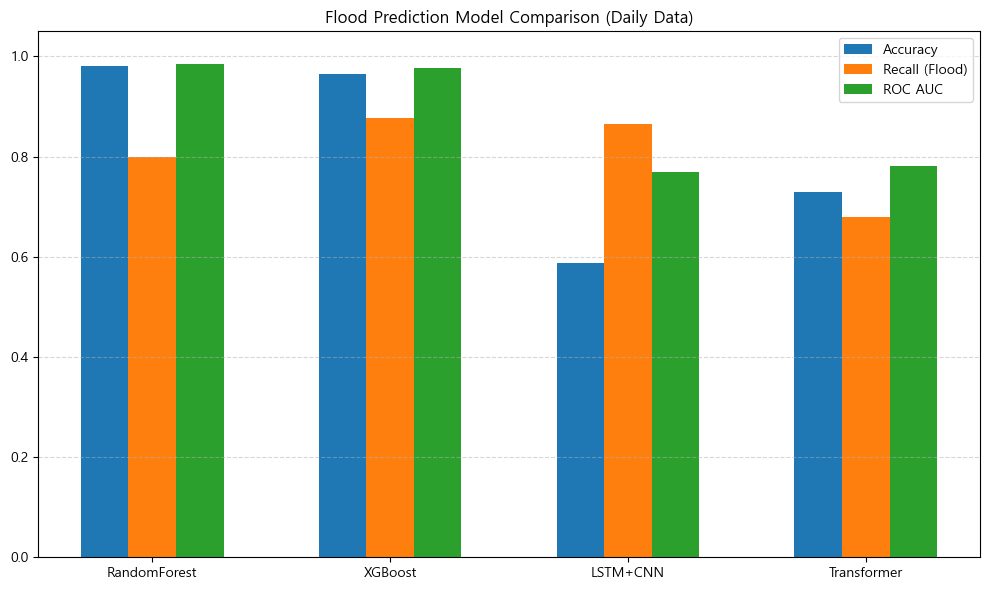

In [18]:
import matplotlib.pyplot as plt

models = ["RandomForest", "XGBoost", "LSTM+CNN", "Transformer"]
accuracy = [0.9811, 0.9641, 0.5873, 0.7299]
recall = [0.8000, 0.8765, 0.8642, 0.6790]
roc_auc = [0.9843, 0.9775, 0.7688, 0.7812]

plt.figure(figsize=(10, 6))
x = range(len(models))

plt.bar(x, accuracy, width=0.2, label="Accuracy", align="center")
plt.bar([i + 0.2 for i in x], recall, width=0.2, label="Recall (Flood)", align="center")
plt.bar([i + 0.4 for i in x], roc_auc, width=0.2, label="ROC AUC", align="center")

plt.xticks([i + 0.2 for i in x], models)
plt.ylim(0, 1.05)
plt.title("Flood Prediction Model Comparison (Daily Data)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("daily_model_comparison.png")
plt.show()

# 한글설정, 워닝제거

In [1]:
# 한글설정
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False     # 마이너스(-) 깨짐 방지

#워닝 제거
import warnings
warnings.filterwarnings('ignore')

# api key 활용 및 데이터 수집

In [2]:
import os
from dotenv import load_dotenv
OPENWEATHER_API_KEY = load_dotenv('.env')
OPENWEATHER_API_KEY = os.getenv('OPENWEATHER_API_KEY')
# print(os.getenv('OPENWEATHER_API_KEY'))

# 데이터 수집하기

In [ ]:
import os
import time
import requests
import pandas as pd
import datetime
import schedule

#  사용자 설정
SERVICE_KEY = os.getenv("OPENWEATHER_API_KEY")
CSV_FILE = 'asos_seoul_daily.csv'
STN_ID = 108
NUM_OF_ROWS = 100
API_URL = "http://apis.data.go.kr/1360000/AsosDalyInfoService/getWthrDataList"

START_DATE = datetime.date(2000, 1, 10)
END_DATE = datetime.date.today() - datetime.timedelta(days=1)

#  기존 날짜 로드
def load_existing_dates():
    if not os.path.exists(CSV_FILE):
        return set()
    df = pd.read_csv(CSV_FILE)
    return set(pd.to_datetime(df['tm']).dt.date.astype(str))

#  하루치 수집 함수
def fetch_day_data(date_obj):
    params = {
        'serviceKey': SERVICE_KEY,
        'numOfRows': NUM_OF_ROWS,
        'pageNo': 1,
        'dataCd': 'ASOS',
        'dateCd': 'DAY',
        'startDt': date_obj.strftime("%Y%m%d"),
        'endDt': date_obj.strftime("%Y%m%d"),
        'stnIds': STN_ID,
        'dataType': 'JSON'
    }

    try:
        response = requests.get(API_URL, params=params, timeout=60)
        response.raise_for_status()
        data = response.json()
        items = data['response']['body']['items'].get('item', [])
        return items
    except Exception as e:
        print(f" [{date_obj}] 에러 발생: {e}")
        return []

#  결측치 많은 컬럼 자동 제거 및 저장
def append_to_csv(items):
    if not items:
        return

    df = pd.DataFrame(items)

    useful_columns = [
        'tm', 'avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm',
        'avgTs', 'ddMefs', 'sumGsr', 'maxInsWs', 'hr3Fhsc',
        'sumSmlEv', 'avgTd', 'avgPs'
    ]
    df = df[[col for col in useful_columns if col in df.columns]]

    #  결측치가 5% 이상인 컬럼 제거
    missing_ratio = df.isna().mean()
    keep_cols = missing_ratio[missing_ratio < 0.05].index.tolist()
    df = df[keep_cols]

    # CSV 저장
    write_header = not os.path.exists(CSV_FILE)
    df.to_csv(CSV_FILE, mode='a', header=write_header, index=False)

#  마지막 수집일 이후로 수집
def get_last_collected_date():
    if not os.path.exists(CSV_FILE):
        return START_DATE
    df = pd.read_csv(CSV_FILE)
    last_date = pd.to_datetime(df['tm']).max().date()
    return last_date + datetime.timedelta(days=1)

#  전체 수집 프로세스
def job():
    existing_dates = load_existing_dates()
    current_date = get_last_collected_date()

    while current_date <= END_DATE:
        if str(current_date) in existing_dates:
            current_date += datetime.timedelta(days=1)
            continue

        items = fetch_day_data(current_date)
        append_to_csv(items)

        print(f" [{current_date}] 저장 완료")
        current_date += datetime.timedelta(days=1)
        time.sleep(0.3)

#  최초 실행
job()

#  매시간마다 자동 실행
schedule.every(1).hours.do(job)
print(" 자동 수집 대기 중...")
while True:
    schedule.run_pending()
    time.sleep(60)

 [2005-04-29] 저장 완료
 [2005-04-30] 저장 완료
 [2005-05-01] 저장 완료
 [2005-05-02] 저장 완료
 [2005-05-03] 저장 완료
 [2005-05-04] 저장 완료
 [2005-05-05] 저장 완료
 [2005-05-06] 저장 완료
 [2005-05-07] 저장 완료
 [2005-05-08] 저장 완료
 [2005-05-09] 저장 완료
 [2005-05-10] 저장 완료
 [2005-05-11] 저장 완료
 [2005-05-12] 저장 완료
 [2005-05-13] 저장 완료
 [2005-05-14] 저장 완료
 [2005-05-15] 저장 완료
 [2005-05-16] 저장 완료
 [2005-05-17] 저장 완료
 [2005-05-18] 저장 완료
 [2005-05-19] 저장 완료
 [2005-05-20] 저장 완료
 [2005-05-21] 저장 완료
 [2005-05-22] 저장 완료
 [2005-05-23] 저장 완료
 [2005-05-24] 저장 완료
 [2005-05-25] 저장 완료
 [2005-05-26] 저장 완료
 [2005-05-27] 저장 완료
 [2005-05-28] 저장 완료
 [2005-05-29] 저장 완료
 [2005-05-30] 저장 완료
 [2005-05-31] 저장 완료
 [2005-06-01] 저장 완료
 [2005-06-02] 저장 완료
 [2005-06-03] 저장 완료
 [2005-06-04] 저장 완료
 [2005-06-05] 저장 완료
 [2005-06-06] 저장 완료
 [2005-06-07] 저장 완료
 [2005-06-08] 저장 완료
 [2005-06-09] 저장 완료
 [2005-06-10] 저장 완료
 [2005-06-11] 저장 완료
 [2005-06-12] 저장 완료
 [2005-06-13] 저장 완료
 [2005-06-14] 저장 완료
 [2005-06-15] 저장 완료
 [2005-06-16] 저장 완료
 [2005-06-17] 저장 완료


 [2006-06-07] 저장 완료
 [2006-06-08] 저장 완료
 [2006-06-09] 저장 완료
 [2006-06-10] 저장 완료
 [2006-06-11] 저장 완료
 [2006-06-12] 저장 완료
 [2006-06-13] 저장 완료
 [2006-06-14] 저장 완료
 [2006-06-15] 저장 완료
 [2006-06-16] 저장 완료
 [2006-06-17] 저장 완료
 [2006-06-18] 저장 완료
 [2006-06-19] 저장 완료
 [2006-06-20] 저장 완료
 [2006-06-21] 저장 완료
 [2006-06-22] 저장 완료
 [2006-06-23] 저장 완료
 [2006-06-24] 저장 완료
 [2006-06-25] 저장 완료
 [2006-06-26] 저장 완료
 [2006-06-27] 저장 완료
 [2006-06-28] 저장 완료
 [2006-06-29] 저장 완료
 [2006-06-30] 저장 완료
 [2006-07-01] 저장 완료
 [2006-07-02] 저장 완료
 [2006-07-03] 저장 완료
 [2006-07-04] 저장 완료
 [2006-07-05] 저장 완료
 [2006-07-06] 저장 완료
 [2006-07-07] 저장 완료
 [2006-07-08] 저장 완료
 [2006-07-09] 저장 완료
 [2006-07-10] 저장 완료
 [2006-07-11] 저장 완료
 [2006-07-12] 저장 완료
 [2006-07-13] 저장 완료
 [2006-07-14] 저장 완료
 [2006-07-15] 저장 완료
 [2006-07-16] 저장 완료
 [2006-07-17] 저장 완료
 [2006-07-18] 저장 완료
 [2006-07-19] 저장 완료
 [2006-07-20] 저장 완료
 [2006-07-21] 저장 완료
 [2006-07-22] 저장 완료
 [2006-07-23] 저장 완료
 [2006-07-24] 저장 완료
 [2006-07-25] 저장 완료
 [2006-07-26] 저장 완료


 [2007-07-13] 저장 완료
 [2007-07-14] 저장 완료
 [2007-07-15] 저장 완료
 [2007-07-16] 저장 완료
 [2007-07-17] 저장 완료
 [2007-07-18] 저장 완료
 [2007-07-19] 저장 완료
 [2007-07-20] 저장 완료
 [2007-07-21] 저장 완료
 [2007-07-22] 저장 완료
 [2007-07-23] 저장 완료
 [2007-07-24] 저장 완료
 [2007-07-25] 저장 완료
 [2007-07-26] 저장 완료
 [2007-07-27] 저장 완료
 [2007-07-28] 저장 완료
 [2007-07-29] 저장 완료
 [2007-07-30] 저장 완료
 [2007-07-31] 저장 완료
 [2007-08-01] 저장 완료
 [2007-08-02] 저장 완료
 [2007-08-03] 저장 완료
❌ [2007-08-04] 에러 발생: Expecting value: line 1 column 1 (char 0)
 [2007-08-04] 저장 완료
 [2007-08-05] 저장 완료
 [2007-08-06] 저장 완료
 [2007-08-07] 저장 완료
 [2007-08-08] 저장 완료
 [2007-08-09] 저장 완료
 [2007-08-10] 저장 완료
 [2007-08-11] 저장 완료
 [2007-08-12] 저장 완료
❌ [2007-08-13] 에러 발생: Expecting value: line 1 column 1 (char 0)
 [2007-08-13] 저장 완료
 [2007-08-14] 저장 완료
 [2007-08-15] 저장 완료
 [2007-08-16] 저장 완료
 [2007-08-17] 저장 완료
 [2007-08-18] 저장 완료
 [2007-08-19] 저장 완료
 [2007-08-20] 저장 완료
 [2007-08-21] 저장 완료
 [2007-08-22] 저장 완료
 [2007-08-23] 저장 완료
 [2007-08-24] 저장 완료
 [2007-08-25

 [2008-08-17] 저장 완료
 [2008-08-18] 저장 완료
 [2008-08-19] 저장 완료
 [2008-08-20] 저장 완료
 [2008-08-21] 저장 완료
 [2008-08-22] 저장 완료
 [2008-08-23] 저장 완료
 [2008-08-24] 저장 완료
 [2008-08-25] 저장 완료
 [2008-08-26] 저장 완료
 [2008-08-27] 저장 완료
 [2008-08-28] 저장 완료
 [2008-08-29] 저장 완료
 [2008-08-30] 저장 완료
 [2008-08-31] 저장 완료
 [2008-09-01] 저장 완료
 [2008-09-02] 저장 완료
 [2008-09-03] 저장 완료
 [2008-09-04] 저장 완료
 [2008-09-05] 저장 완료
 [2008-09-06] 저장 완료
 [2008-09-07] 저장 완료
 [2008-09-08] 저장 완료
 [2008-09-09] 저장 완료
 [2008-09-10] 저장 완료
 [2008-09-11] 저장 완료
 [2008-09-12] 저장 완료
 [2008-09-13] 저장 완료
 [2008-09-14] 저장 완료
 [2008-09-15] 저장 완료
 [2008-09-16] 저장 완료
 [2008-09-17] 저장 완료
 [2008-09-18] 저장 완료
 [2008-09-19] 저장 완료
 [2008-09-20] 저장 완료
 [2008-09-21] 저장 완료
 [2008-09-22] 저장 완료
 [2008-09-23] 저장 완료
 [2008-09-24] 저장 완료
 [2008-09-25] 저장 완료
 [2008-09-26] 저장 완료
 [2008-09-27] 저장 완료
 [2008-09-28] 저장 완료
 [2008-09-29] 저장 완료
 [2008-09-30] 저장 완료
 [2008-10-01] 저장 완료
 [2008-10-02] 저장 완료
 [2008-10-03] 저장 완료
 [2008-10-04] 저장 완료
 [2008-10-05] 저장 완료


 [2009-09-18] 저장 완료
 [2009-09-19] 저장 완료
 [2009-09-20] 저장 완료
 [2009-09-21] 저장 완료
 [2009-09-22] 저장 완료
 [2009-09-23] 저장 완료
 [2009-09-24] 저장 완료
 [2009-09-25] 저장 완료
 [2009-09-26] 저장 완료
 [2009-09-27] 저장 완료
 [2009-09-28] 저장 완료
 [2009-09-29] 저장 완료
 [2009-09-30] 저장 완료
 [2009-10-01] 저장 완료
 [2009-10-02] 저장 완료
 [2009-10-03] 저장 완료
 [2009-10-04] 저장 완료
 [2009-10-05] 저장 완료
 [2009-10-06] 저장 완료
 [2009-10-07] 저장 완료
 [2009-10-08] 저장 완료
 [2009-10-09] 저장 완료
 [2009-10-10] 저장 완료
 [2009-10-11] 저장 완료
 [2009-10-12] 저장 완료
 [2009-10-13] 저장 완료
 [2009-10-14] 저장 완료
 [2009-10-15] 저장 완료
 [2009-10-16] 저장 완료
 [2009-10-17] 저장 완료
 [2009-10-18] 저장 완료
 [2009-10-19] 저장 완료
 [2009-10-20] 저장 완료
 [2009-10-21] 저장 완료
 [2009-10-22] 저장 완료
 [2009-10-23] 저장 완료
 [2009-10-24] 저장 완료
 [2009-10-25] 저장 완료
 [2009-10-26] 저장 완료
 [2009-10-27] 저장 완료
 [2009-10-28] 저장 완료
 [2009-10-29] 저장 완료
 [2009-10-30] 저장 완료
 [2009-10-31] 저장 완료
 [2009-11-01] 저장 완료
 [2009-11-02] 저장 완료
 [2009-11-03] 저장 완료
 [2009-11-04] 저장 완료
 [2009-11-05] 저장 완료
 [2009-11-06] 저장 완료


 [2010-10-11] 저장 완료
 [2010-10-12] 저장 완료
 [2010-10-13] 저장 완료
 [2010-10-14] 저장 완료
 [2010-10-15] 저장 완료
 [2010-10-16] 저장 완료
 [2010-10-17] 저장 완료
 [2010-10-18] 저장 완료
 [2010-10-19] 저장 완료
 [2010-10-20] 저장 완료
 [2010-10-21] 저장 완료
 [2010-10-22] 저장 완료
 [2010-10-23] 저장 완료
 [2010-10-24] 저장 완료
 [2010-10-25] 저장 완료
 [2010-10-26] 저장 완료
 [2010-10-27] 저장 완료
 [2010-10-28] 저장 완료
 [2010-10-29] 저장 완료
 [2010-10-30] 저장 완료
 [2010-10-31] 저장 완료
 [2010-11-01] 저장 완료
 [2010-11-02] 저장 완료
 [2010-11-03] 저장 완료
 [2010-11-04] 저장 완료
 [2010-11-05] 저장 완료
 [2010-11-06] 저장 완료
 [2010-11-07] 저장 완료
 [2010-11-08] 저장 완료
 [2010-11-09] 저장 완료
 [2010-11-10] 저장 완료
 [2010-11-11] 저장 완료
 [2010-11-12] 저장 완료
 [2010-11-13] 저장 완료
 [2010-11-14] 저장 완료
 [2010-11-15] 저장 완료
 [2010-11-16] 저장 완료
 [2010-11-17] 저장 완료
 [2010-11-18] 저장 완료
 [2010-11-19] 저장 완료
 [2010-11-20] 저장 완료
 [2010-11-21] 저장 완료
 [2010-11-22] 저장 완료
 [2010-11-23] 저장 완료
 [2010-11-24] 저장 완료
 [2010-11-25] 저장 완료
 [2010-11-26] 저장 완료
 [2010-11-27] 저장 완료
 [2010-11-28] 저장 완료
 [2010-11-29] 저장 완료


 [2011-11-25] 저장 완료
 [2011-11-26] 저장 완료
 [2011-11-27] 저장 완료
 [2011-11-28] 저장 완료
 [2011-11-29] 저장 완료
 [2011-11-30] 저장 완료
 [2011-12-01] 저장 완료
 [2011-12-02] 저장 완료
 [2011-12-03] 저장 완료
 [2011-12-04] 저장 완료
 [2011-12-05] 저장 완료
 [2011-12-06] 저장 완료
 [2011-12-07] 저장 완료
 [2011-12-08] 저장 완료
 [2011-12-09] 저장 완료
 [2011-12-10] 저장 완료
 [2011-12-11] 저장 완료
 [2011-12-12] 저장 완료
 [2011-12-13] 저장 완료
 [2011-12-14] 저장 완료
 [2011-12-15] 저장 완료
 [2011-12-16] 저장 완료
 [2011-12-17] 저장 완료
 [2011-12-18] 저장 완료
 [2011-12-19] 저장 완료
 [2011-12-20] 저장 완료
 [2011-12-21] 저장 완료
 [2011-12-22] 저장 완료
 [2011-12-23] 저장 완료
 [2011-12-24] 저장 완료
 [2011-12-25] 저장 완료
 [2011-12-26] 저장 완료
 [2011-12-27] 저장 완료
 [2011-12-28] 저장 완료
 [2011-12-29] 저장 완료
 [2011-12-30] 저장 완료
 [2011-12-31] 저장 완료
 [2012-01-01] 저장 완료
 [2012-01-02] 저장 완료
 [2012-01-03] 저장 완료
 [2012-01-04] 저장 완료
 [2012-01-05] 저장 완료
 [2012-01-06] 저장 완료
 [2012-01-07] 저장 완료
 [2012-01-08] 저장 완료
 [2012-01-09] 저장 완료
 [2012-01-10] 저장 완료
 [2012-01-11] 저장 완료
 [2012-01-12] 저장 완료
 [2012-01-13] 저장 완료


 [2013-01-02] 저장 완료
 [2013-01-03] 저장 완료
 [2013-01-04] 저장 완료
 [2013-01-05] 저장 완료
 [2013-01-06] 저장 완료
 [2013-01-07] 저장 완료
 [2013-01-08] 저장 완료
 [2013-01-09] 저장 완료
 [2013-01-10] 저장 완료
 [2013-01-11] 저장 완료
 [2013-01-12] 저장 완료
 [2013-01-13] 저장 완료
 [2013-01-14] 저장 완료
 [2013-01-15] 저장 완료
 [2013-01-16] 저장 완료
 [2013-01-17] 저장 완료
 [2013-01-18] 저장 완료
 [2013-01-19] 저장 완료
 [2013-01-20] 저장 완료
 [2013-01-21] 저장 완료
 [2013-01-22] 저장 완료
 [2013-01-23] 저장 완료
 [2013-01-24] 저장 완료
 [2013-01-25] 저장 완료
 [2013-01-26] 저장 완료
 [2013-01-27] 저장 완료
 [2013-01-28] 저장 완료
 [2013-01-29] 저장 완료
 [2013-01-30] 저장 완료
 [2013-01-31] 저장 완료
 [2013-02-01] 저장 완료
 [2013-02-02] 저장 완료
 [2013-02-03] 저장 완료
 [2013-02-04] 저장 완료
 [2013-02-05] 저장 완료
 [2013-02-06] 저장 완료
 [2013-02-07] 저장 완료
 [2013-02-08] 저장 완료
 [2013-02-09] 저장 완료
 [2013-02-10] 저장 완료
 [2013-02-11] 저장 완료
 [2013-02-12] 저장 완료
 [2013-02-13] 저장 완료
 [2013-02-14] 저장 완료
 [2013-02-15] 저장 완료
 [2013-02-16] 저장 완료
 [2013-02-17] 저장 완료
 [2013-02-18] 저장 완료
 [2013-02-19] 저장 완료
 [2013-02-20] 저장 완료


 [2014-02-10] 저장 완료
 [2014-02-11] 저장 완료
 [2014-02-12] 저장 완료
 [2014-02-13] 저장 완료
 [2014-02-14] 저장 완료
 [2014-02-15] 저장 완료
 [2014-02-16] 저장 완료
 [2014-02-17] 저장 완료
 [2014-02-18] 저장 완료
 [2014-02-19] 저장 완료
 [2014-02-20] 저장 완료
 [2014-02-21] 저장 완료
 [2014-02-22] 저장 완료
 [2014-02-23] 저장 완료
 [2014-02-24] 저장 완료
 [2014-02-25] 저장 완료
 [2014-02-26] 저장 완료
 [2014-02-27] 저장 완료
 [2014-02-28] 저장 완료
 [2014-03-01] 저장 완료
 [2014-03-02] 저장 완료
 [2014-03-03] 저장 완료
 [2014-03-04] 저장 완료
 [2014-03-05] 저장 완료
 [2014-03-06] 저장 완료
 [2014-03-07] 저장 완료
 [2014-03-08] 저장 완료
 [2014-03-09] 저장 완료
 [2014-03-10] 저장 완료
 [2014-03-11] 저장 완료
 [2014-03-12] 저장 완료
 [2014-03-13] 저장 완료
 [2014-03-14] 저장 완료
 [2014-03-15] 저장 완료
 [2014-03-16] 저장 완료
 [2014-03-17] 저장 완료
 [2014-03-18] 저장 완료
 [2014-03-19] 저장 완료
 [2014-03-20] 저장 완료
 [2014-03-21] 저장 완료
 [2014-03-22] 저장 완료
 [2014-03-23] 저장 완료
 [2014-03-24] 저장 완료
 [2014-03-25] 저장 완료
 [2014-03-26] 저장 완료
 [2014-03-27] 저장 완료
 [2014-03-28] 저장 완료
 [2014-03-29] 저장 완료
 [2014-03-30] 저장 완료
 [2014-03-31] 저장 완료


 [2015-02-23] 저장 완료
 [2015-02-24] 저장 완료
 [2015-02-25] 저장 완료
 [2015-02-26] 저장 완료
 [2015-02-27] 저장 완료
 [2015-02-28] 저장 완료
 [2015-03-01] 저장 완료
 [2015-03-02] 저장 완료
 [2015-03-03] 저장 완료
 [2015-03-04] 저장 완료
 [2015-03-05] 저장 완료
 [2015-03-06] 저장 완료
 [2015-03-07] 저장 완료
 [2015-03-08] 저장 완료
 [2015-03-09] 저장 완료
 [2015-03-10] 저장 완료
 [2015-03-11] 저장 완료
 [2015-03-12] 저장 완료
 [2015-03-13] 저장 완료
 [2015-03-14] 저장 완료
 [2015-03-15] 저장 완료
 [2015-03-16] 저장 완료
 [2015-03-17] 저장 완료
 [2015-03-18] 저장 완료
 [2015-03-19] 저장 완료
 [2015-03-20] 저장 완료
 [2015-03-21] 저장 완료
 [2015-03-22] 저장 완료
 [2015-03-23] 저장 완료
 [2015-03-24] 저장 완료
 [2015-03-25] 저장 완료
 [2015-03-26] 저장 완료
 [2015-03-27] 저장 완료
 [2015-03-28] 저장 완료
 [2015-03-29] 저장 완료
 [2015-03-30] 저장 완료
 [2015-03-31] 저장 완료
 [2015-04-01] 저장 완료
 [2015-04-02] 저장 완료
 [2015-04-03] 저장 완료
 [2015-04-04] 저장 완료
 [2015-04-05] 저장 완료
 [2015-04-06] 저장 완료
 [2015-04-07] 저장 완료
 [2015-04-08] 저장 완료
 [2015-04-09] 저장 완료
 [2015-04-10] 저장 완료
 [2015-04-11] 저장 완료
 [2015-04-12] 저장 완료
 [2015-04-13] 저장 완료


 [2016-03-26] 저장 완료
 [2016-03-27] 저장 완료
 [2016-03-28] 저장 완료
 [2016-03-29] 저장 완료
 [2016-03-30] 저장 완료
 [2016-03-31] 저장 완료
 [2016-04-01] 저장 완료
 [2016-04-02] 저장 완료
 [2016-04-03] 저장 완료
 [2016-04-04] 저장 완료
 [2016-04-05] 저장 완료
 [2016-04-06] 저장 완료
 [2016-04-07] 저장 완료
 [2016-04-08] 저장 완료
 [2016-04-09] 저장 완료
 [2016-04-10] 저장 완료
 [2016-04-11] 저장 완료
 [2016-04-12] 저장 완료
 [2016-04-13] 저장 완료
 [2016-04-14] 저장 완료
 [2016-04-15] 저장 완료
 [2016-04-16] 저장 완료
 [2016-04-17] 저장 완료
 [2016-04-18] 저장 완료
 [2016-04-19] 저장 완료
 [2016-04-20] 저장 완료
 [2016-04-21] 저장 완료
 [2016-04-22] 저장 완료
 [2016-04-23] 저장 완료
 [2016-04-24] 저장 완료
 [2016-04-25] 저장 완료
 [2016-04-26] 저장 완료
 [2016-04-27] 저장 완료
 [2016-04-28] 저장 완료
 [2016-04-29] 저장 완료
 [2016-04-30] 저장 완료
 [2016-05-01] 저장 완료
 [2016-05-02] 저장 완료
 [2016-05-03] 저장 완료
 [2016-05-04] 저장 완료
 [2016-05-05] 저장 완료
 [2016-05-06] 저장 완료
 [2016-05-07] 저장 완료
 [2016-05-08] 저장 완료
 [2016-05-09] 저장 완료
 [2016-05-10] 저장 완료
 [2016-05-11] 저장 완료
 [2016-05-12] 저장 완료
 [2016-05-13] 저장 완료
 [2016-05-14] 저장 완료


 [2017-04-24] 저장 완료
 [2017-04-25] 저장 완료
 [2017-04-26] 저장 완료
 [2017-04-27] 저장 완료
 [2017-04-28] 저장 완료
 [2017-04-29] 저장 완료
 [2017-04-30] 저장 완료
 [2017-05-01] 저장 완료
 [2017-05-02] 저장 완료
 [2017-05-03] 저장 완료
 [2017-05-04] 저장 완료
 [2017-05-05] 저장 완료
 [2017-05-06] 저장 완료
 [2017-05-07] 저장 완료
 [2017-05-08] 저장 완료
 [2017-05-09] 저장 완료
 [2017-05-10] 저장 완료
 [2017-05-11] 저장 완료
 [2017-05-12] 저장 완료
 [2017-05-13] 저장 완료
 [2017-05-14] 저장 완료
 [2017-05-15] 저장 완료
 [2017-05-16] 저장 완료
 [2017-05-17] 저장 완료
 [2017-05-18] 저장 완료
 [2017-05-19] 저장 완료
 [2017-05-20] 저장 완료
 [2017-05-21] 저장 완료
 [2017-05-22] 저장 완료
 [2017-05-23] 저장 완료
 [2017-05-24] 저장 완료
 [2017-05-25] 저장 완료
 [2017-05-26] 저장 완료
 [2017-05-27] 저장 완료
 [2017-05-28] 저장 완료
 [2017-05-29] 저장 완료
 [2017-05-30] 저장 완료
 [2017-05-31] 저장 완료
 [2017-06-01] 저장 완료
 [2017-06-02] 저장 완료
 [2017-06-03] 저장 완료
 [2017-06-04] 저장 완료
 [2017-06-05] 저장 완료
 [2017-06-06] 저장 완료
 [2017-06-07] 저장 완료
 [2017-06-08] 저장 완료
 [2017-06-09] 저장 완료
 [2017-06-10] 저장 완료
 [2017-06-11] 저장 완료
 [2017-06-12] 저장 완료


 [2018-05-30] 저장 완료
 [2018-05-31] 저장 완료
 [2018-06-01] 저장 완료
 [2018-06-02] 저장 완료
 [2018-06-03] 저장 완료
 [2018-06-04] 저장 완료
 [2018-06-05] 저장 완료
 [2018-06-06] 저장 완료
 [2018-06-07] 저장 완료
 [2018-06-08] 저장 완료
 [2018-06-09] 저장 완료
 [2018-06-10] 저장 완료
 [2018-06-11] 저장 완료
 [2018-06-12] 저장 완료
 [2018-06-13] 저장 완료
 [2018-06-14] 저장 완료
 [2018-06-15] 저장 완료
 [2018-06-16] 저장 완료
 [2018-06-17] 저장 완료
 [2018-06-18] 저장 완료
 [2018-06-19] 저장 완료
 [2018-06-20] 저장 완료
 [2018-06-21] 저장 완료
 [2018-06-22] 저장 완료
 [2018-06-23] 저장 완료
 [2018-06-24] 저장 완료
 [2018-06-25] 저장 완료
 [2018-06-26] 저장 완료
 [2018-06-27] 저장 완료
 [2018-06-28] 저장 완료
 [2018-06-29] 저장 완료
 [2018-06-30] 저장 완료
 [2018-07-01] 저장 완료
 [2018-07-02] 저장 완료
 [2018-07-03] 저장 완료
 [2018-07-04] 저장 완료
 [2018-07-05] 저장 완료
 [2018-07-06] 저장 완료
 [2018-07-07] 저장 완료
 [2018-07-08] 저장 완료
 [2018-07-09] 저장 완료
 [2018-07-10] 저장 완료
 [2018-07-11] 저장 완료
 [2018-07-12] 저장 완료
 [2018-07-13] 저장 완료
 [2018-07-14] 저장 완료
 [2018-07-15] 저장 완료
 [2018-07-16] 저장 완료
 [2018-07-17] 저장 완료
 [2018-07-18] 저장 완료


 [2019-07-08] 저장 완료
 [2019-07-09] 저장 완료
 [2019-07-10] 저장 완료
 [2019-07-11] 저장 완료
 [2019-07-12] 저장 완료
 [2019-07-13] 저장 완료
 [2019-07-14] 저장 완료
 [2019-07-15] 저장 완료
 [2019-07-16] 저장 완료
 [2019-07-17] 저장 완료
 [2019-07-18] 저장 완료
 [2019-07-19] 저장 완료
 [2019-07-20] 저장 완료
 [2019-07-21] 저장 완료
 [2019-07-22] 저장 완료
 [2019-07-23] 저장 완료
 [2019-07-24] 저장 완료
 [2019-07-25] 저장 완료
 [2019-07-26] 저장 완료
 [2019-07-27] 저장 완료
 [2019-07-28] 저장 완료
 [2019-07-29] 저장 완료
 [2019-07-30] 저장 완료
 [2019-07-31] 저장 완료
 [2019-08-01] 저장 완료
 [2019-08-02] 저장 완료
 [2019-08-03] 저장 완료
 [2019-08-04] 저장 완료
 [2019-08-05] 저장 완료
 [2019-08-06] 저장 완료
 [2019-08-07] 저장 완료
 [2019-08-08] 저장 완료
 [2019-08-09] 저장 완료
 [2019-08-10] 저장 완료
 [2019-08-11] 저장 완료
 [2019-08-12] 저장 완료
 [2019-08-13] 저장 완료
 [2019-08-14] 저장 완료
 [2019-08-15] 저장 완료
 [2019-08-16] 저장 완료
 [2019-08-17] 저장 완료
 [2019-08-18] 저장 완료
 [2019-08-19] 저장 완료
 [2019-08-20] 저장 완료
 [2019-08-21] 저장 완료
 [2019-08-22] 저장 완료
 [2019-08-23] 저장 완료
 [2019-08-24] 저장 완료
 [2019-08-25] 저장 완료
 [2019-08-26] 저장 완료


 [2020-08-15] 저장 완료
 [2020-08-16] 저장 완료
 [2020-08-17] 저장 완료
 [2020-08-18] 저장 완료
 [2020-08-19] 저장 완료
 [2020-08-20] 저장 완료
 [2020-08-21] 저장 완료
 [2020-08-22] 저장 완료
 [2020-08-23] 저장 완료
 [2020-08-24] 저장 완료
 [2020-08-25] 저장 완료
 [2020-08-26] 저장 완료
 [2020-08-27] 저장 완료
 [2020-08-28] 저장 완료
 [2020-08-29] 저장 완료
 [2020-08-30] 저장 완료
 [2020-08-31] 저장 완료
 [2020-09-01] 저장 완료
 [2020-09-02] 저장 완료
 [2020-09-03] 저장 완료
 [2020-09-04] 저장 완료
 [2020-09-05] 저장 완료
 [2020-09-06] 저장 완료
 [2020-09-07] 저장 완료
 [2020-09-08] 저장 완료
 [2020-09-09] 저장 완료
 [2020-09-10] 저장 완료
 [2020-09-11] 저장 완료
 [2020-09-12] 저장 완료
 [2020-09-13] 저장 완료
 [2020-09-14] 저장 완료
 [2020-09-15] 저장 완료
 [2020-09-16] 저장 완료
 [2020-09-17] 저장 완료
 [2020-09-18] 저장 완료
 [2020-09-19] 저장 완료
 [2020-09-20] 저장 완료
 [2020-09-21] 저장 완료
 [2020-09-22] 저장 완료
 [2020-09-23] 저장 완료
 [2020-09-24] 저장 완료
 [2020-09-25] 저장 완료
 [2020-09-26] 저장 완료
 [2020-09-27] 저장 완료
 [2020-09-28] 저장 완료
 [2020-09-29] 저장 완료
 [2020-09-30] 저장 완료
 [2020-10-01] 저장 완료
 [2020-10-02] 저장 완료
 [2020-10-03] 저장 완료


 [2021-09-23] 저장 완료
 [2021-09-24] 저장 완료
 [2021-09-25] 저장 완료
 [2021-09-26] 저장 완료
 [2021-09-27] 저장 완료
 [2021-09-28] 저장 완료
 [2021-09-29] 저장 완료
 [2021-09-30] 저장 완료
 [2021-10-01] 저장 완료
 [2021-10-02] 저장 완료
 [2021-10-03] 저장 완료
 [2021-10-04] 저장 완료
 [2021-10-05] 저장 완료
 [2021-10-06] 저장 완료
 [2021-10-07] 저장 완료
 [2021-10-08] 저장 완료
 [2021-10-09] 저장 완료
 [2021-10-10] 저장 완료
 [2021-10-11] 저장 완료
 [2021-10-12] 저장 완료
 [2021-10-13] 저장 완료
 [2021-10-14] 저장 완료
 [2021-10-15] 저장 완료
 [2021-10-16] 저장 완료
 [2021-10-17] 저장 완료
 [2021-10-18] 저장 완료
 [2021-10-19] 저장 완료
 [2021-10-20] 저장 완료
 [2021-10-21] 저장 완료
 [2021-10-22] 저장 완료
 [2021-10-23] 저장 완료
 [2021-10-24] 저장 완료
 [2021-10-25] 저장 완료
 [2021-10-26] 저장 완료
 [2021-10-27] 저장 완료
 [2021-10-28] 저장 완료
 [2021-10-29] 저장 완료
 [2021-10-30] 저장 완료
 [2021-10-31] 저장 완료
 [2021-11-01] 저장 완료
 [2021-11-02] 저장 완료
 [2021-11-03] 저장 완료
 [2021-11-04] 저장 완료
 [2021-11-05] 저장 완료
 [2021-11-06] 저장 완료
 [2021-11-07] 저장 완료
 [2021-11-08] 저장 완료
 [2021-11-09] 저장 완료
 [2021-11-10] 저장 완료
 [2021-11-11] 저장 완료


 [2022-11-07] 저장 완료
 [2022-11-08] 저장 완료
 [2022-11-09] 저장 완료
 [2022-11-10] 저장 완료
 [2022-11-11] 저장 완료
 [2022-11-12] 저장 완료
 [2022-11-13] 저장 완료
 [2022-11-14] 저장 완료
 [2022-11-15] 저장 완료
 [2022-11-16] 저장 완료
 [2022-11-17] 저장 완료
 [2022-11-18] 저장 완료
 [2022-11-19] 저장 완료
 [2022-11-20] 저장 완료
 [2022-11-21] 저장 완료
 [2022-11-22] 저장 완료
 [2022-11-23] 저장 완료
 [2022-11-24] 저장 완료
 [2022-11-25] 저장 완료
 [2022-11-26] 저장 완료
 [2022-11-27] 저장 완료
 [2022-11-28] 저장 완료
 [2022-11-29] 저장 완료
 [2022-11-30] 저장 완료
 [2022-12-01] 저장 완료
 [2022-12-02] 저장 완료
 [2022-12-03] 저장 완료
 [2022-12-04] 저장 완료
 [2022-12-05] 저장 완료
 [2022-12-06] 저장 완료
 [2022-12-07] 저장 완료
 [2022-12-08] 저장 완료
 [2022-12-09] 저장 완료
 [2022-12-10] 저장 완료
 [2022-12-11] 저장 완료
 [2022-12-12] 저장 완료
 [2022-12-13] 저장 완료
 [2022-12-14] 저장 완료
 [2022-12-15] 저장 완료
 [2022-12-16] 저장 완료
 [2022-12-17] 저장 완료
 [2022-12-18] 저장 완료
 [2022-12-19] 저장 완료
 [2022-12-20] 저장 완료
 [2022-12-21] 저장 완료
 [2022-12-22] 저장 완료
 [2022-12-23] 저장 완료
 [2022-12-24] 저장 완료
 [2022-12-25] 저장 완료
 [2022-12-26] 저장 완료


 [2023-12-16] 저장 완료
 [2023-12-17] 저장 완료
 [2023-12-18] 저장 완료
 [2023-12-19] 저장 완료
 [2023-12-20] 저장 완료
 [2023-12-21] 저장 완료
 [2023-12-22] 저장 완료
 [2023-12-23] 저장 완료
 [2023-12-24] 저장 완료
 [2023-12-25] 저장 완료
 [2023-12-26] 저장 완료
 [2023-12-27] 저장 완료
 [2023-12-28] 저장 완료
 [2023-12-29] 저장 완료
 [2023-12-30] 저장 완료
 [2023-12-31] 저장 완료
 [2024-01-01] 저장 완료
 [2024-01-02] 저장 완료
 [2024-01-03] 저장 완료
 [2024-01-04] 저장 완료
 [2024-01-05] 저장 완료
 [2024-01-06] 저장 완료
 [2024-01-07] 저장 완료
 [2024-01-08] 저장 완료
 [2024-01-09] 저장 완료
 [2024-01-10] 저장 완료
 [2024-01-11] 저장 완료
 [2024-01-12] 저장 완료
 [2024-01-13] 저장 완료
 [2024-01-14] 저장 완료
 [2024-01-15] 저장 완료
 [2024-01-16] 저장 완료
 [2024-01-17] 저장 완료
 [2024-01-18] 저장 완료
 [2024-01-19] 저장 완료
 [2024-01-20] 저장 완료
 [2024-01-21] 저장 완료
 [2024-01-22] 저장 완료
 [2024-01-23] 저장 완료
 [2024-01-24] 저장 완료
 [2024-01-25] 저장 완료
 [2024-01-26] 저장 완료
 [2024-01-27] 저장 완료
 [2024-01-28] 저장 완료
 [2024-01-29] 저장 완료
 [2024-01-30] 저장 완료
 [2024-01-31] 저장 완료
 [2024-02-01] 저장 완료
 [2024-02-02] 저장 완료
 [2024-02-03] 저장 완료


 [2025-01-16] 저장 완료
 [2025-01-17] 저장 완료
 [2025-01-18] 저장 완료
 [2025-01-19] 저장 완료
 [2025-01-20] 저장 완료
 [2025-01-21] 저장 완료
 [2025-01-22] 저장 완료
 [2025-01-23] 저장 완료
 [2025-01-24] 저장 완료
 [2025-01-25] 저장 완료
 [2025-01-26] 저장 완료
 [2025-01-27] 저장 완료
 [2025-01-28] 저장 완료
 [2025-01-29] 저장 완료
 [2025-01-30] 저장 완료
 [2025-01-31] 저장 완료
 [2025-02-01] 저장 완료
 [2025-02-02] 저장 완료
 [2025-02-03] 저장 완료
 [2025-02-04] 저장 완료
 [2025-02-05] 저장 완료
 [2025-02-06] 저장 완료
 [2025-02-07] 저장 완료
 [2025-02-08] 저장 완료
 [2025-02-09] 저장 완료
 [2025-02-10] 저장 완료
 [2025-02-11] 저장 완료
 [2025-02-12] 저장 완료
 [2025-02-13] 저장 완료
 [2025-02-14] 저장 완료
 [2025-02-15] 저장 완료
 [2025-02-16] 저장 완료
 [2025-02-17] 저장 완료
 [2025-02-18] 저장 완료
 [2025-02-19] 저장 완료
 [2025-02-20] 저장 완료
 [2025-02-21] 저장 완료
 [2025-02-22] 저장 완료
 [2025-02-23] 저장 완료
 [2025-02-24] 저장 완료
 [2025-02-25] 저장 완료
 [2025-02-26] 저장 완료
 [2025-02-27] 저장 완료
 [2025-02-28] 저장 완료
 [2025-03-01] 저장 완료
 [2025-03-02] 저장 완료
 [2025-03-03] 저장 완료
 [2025-03-04] 저장 완료
 [2025-03-05] 저장 완료
 [2025-03-06] 저장 완료


# 결측치 확인

In [3]:
import pandas as pd

df = pd.read_csv("asos_seoul_daily.csv")  # 저장된 파일명에 맞게 수정

# 결측치 개수 확인
missing_summary = df.isnull().sum()
print(" 결측치 현황:\n", missing_summary)


 결측치 현황:
 tm             0
avgTa          0
minTa          1
maxTa          1
sumRn       5625
avgWs          8
avgRhm         0
avgTs          1
ddMefs      8918
sumGsr        32
maxInsWs       6
sumSmlEv      28
avgTd          0
avgPs          1
dtype: int64


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9249 entries, 0 to 9248
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tm        9249 non-null   object 
 1   avgTa     9249 non-null   float64
 2   minTa     9248 non-null   float64
 3   maxTa     9248 non-null   float64
 4   sumRn     3624 non-null   float64
 5   avgWs     9241 non-null   float64
 6   avgRhm    9249 non-null   float64
 7   avgTs     9248 non-null   float64
 8   ddMefs    331 non-null    float64
 9   sumGsr    9217 non-null   float64
 10  maxInsWs  9243 non-null   float64
 11  sumSmlEv  9221 non-null   float64
 12  avgTd     9249 non-null   float64
 13  avgPs     9248 non-null   float64
dtypes: float64(13), object(1)
memory usage: 1011.7+ KB


# 결측치 처리
```
결측치 처리 기준
컬럼명	설명 (한국어)	결측치 처리 방법
tm	날짜	 그대로 둠
avgTa	평균기온(℃)	없음
minTa, maxTa	최저/최고기온	 중간값 대체
sumRn	강수량합(mm)	 0으로 대체 (비 없었을 확률 높음)
avgWs	평균 풍속(m/s)	 중간값 대체
avgRhm	평균 상대습도(%)	없음
avgTs	평균 지면온도(℃)	 중간값 대체
ddMefs	초상일수(눈 등)	 드롭 or 0 처리
sumGsr	일조시간 합계(hr)	 중간값 대체
maxInsWs	최대 순간풍속(m/s)	 중간값 대체
sumSmlEv	소형 증발량(mm)	 중간값 대체
avgTd	평균 이슬점온도(℃)	없음
avgPs	평균 해면기압(hPa)	 중간값 대체
```

In [6]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("asos_seoul_daily.csv")

# 날짜 처리
df['tm'] = pd.to_datetime(df['tm'])
df['month'] = df['tm'].dt.month
df['dayofweek'] = df['tm'].dt.dayofweek
df['year'] = df['tm'].dt.year

# 결측치 처리
df['sumRn'] = df['sumRn'].fillna(0)
median_cols = ['minTa', 'maxTa', 'avgWs', 'avgTs', 'sumGsr', 'maxInsWs', 'sumSmlEv', 'avgPs']
for col in median_cols:
    df[col] = df[col].fillna(df[col].median())

# 눈 관련 결측치는 드롭 또는 0
df['ddMefs'] = df['ddMefs'].fillna(0)

# 확인
print(" 전처리 완료. 결측치 재확인:\n", df.isnull().sum())


 전처리 완료. 결측치 재확인:
 tm           0
avgTa        0
minTa        0
maxTa        0
sumRn        0
avgWs        0
avgRhm       0
avgTs        0
ddMefs       0
sumGsr       0
maxInsWs     0
sumSmlEv     0
avgTd        0
avgPs        0
month        0
dayofweek    0
year         0
dtype: int64


# 실체 침수사례 포함 머신러닝용 데이터 만들기

In [9]:
import pandas as pd
from datetime import datetime, timedelta

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily.csv")

# 2. 날짜 컬럼 처리
df['tm'] = pd.to_datetime(df['tm'])

# 3. 침수 사례 날짜 목록 정의
flood_periods = [
    ("2000-08-23", "2000-09-01"),
    ("2002-08-30", "2002-09-01"),
    ("2005-08-02", "2005-08-11"),
    ("2006-07-09", "2006-07-29"),
    ("2007-09-13", "2007-09-13"),
    ("2011-07-26", "2011-07-29"),
    ("2013-07-11", "2013-07-15"),
    ("2013-07-18", "2013-07-18"),
    ("2018-08-23", "2018-08-24"),
    ("2018-08-26", "2018-09-01"),
    ("2019-09-28", "2019-10-03"),
    ("2020-07-28", "2020-08-11"),
    ("2020-08-28", "2020-09-03"),
    ("2020-09-01", "2020-09-07"),
    ("2022-08-08", "2022-08-17"),
    ("2022-08-28", "2022-09-06")
]

# 4. 침수 날짜 생성
flood_dates = set()
for start_str, end_str in flood_periods:
    start = datetime.strptime(start_str, "%Y-%m-%d")
    end = datetime.strptime(end_str, "%Y-%m-%d")
    while start <= end:
        flood_dates.add(start.date())
        start += timedelta(days=1)

# 5. 침수 위험 라벨 초기화
df['flood_risk'] = 0

# 6. 침수 사례 날짜에 flood_risk = 1 설정
df.loc[df['tm'].dt.date.isin(flood_dates), 'flood_risk'] = 1

# 7. 강수량 30mm 이상인 날짜도 flood_risk = 1로 설정
df.loc[df['sumRn'] >= 30, 'flood_risk'] = 1

# 8. 저장
df.to_csv("asos_seoul_daily_with_flood_risk.csv", index=False)

# 9. 통계 확인
print("총 데이터 수:", len(df))
print("flood_risk=1 개수:", (df['flood_risk'] == 1).sum())
print("flood_risk=0 개수:", (df['flood_risk'] == 0).sum())

총 데이터 수: 9249
flood_risk=1 개수: 423
flood_risk=0 개수: 8826


# RandomForest (SMOTE 적용) 
- 미적용시 성능 비교결과 recall 수치가 의미 없음

 Confusion Matrix:
 [[1747   18]
 [  17   68]]

 Classification Report:
               precision    recall  f1-score   support

           0     0.9904    0.9898    0.9901      1765
           1     0.7907    0.8000    0.7953        85

    accuracy                         0.9811      1850
   macro avg     0.8905    0.8949    0.8927      1850
weighted avg     0.9812    0.9811    0.9811      1850


 ROC AUC Score: 0.9842959506748875


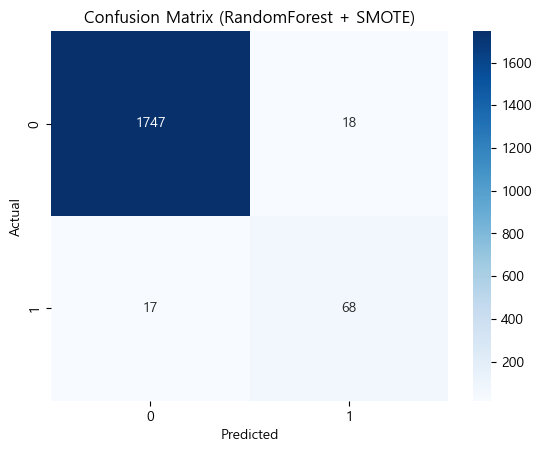

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기
df = pd.read_csv("asos_seoul_daily_with_flood_risk.csv")  # 파일명은 맞게 조정

# 2. 결측치 처리 (30mm 이상 강수량이 있는 경우 포함시키기 위한 전처리)
df['sumRn'] = df['sumRn'].fillna(0)
numeric_cols = ['avgTa', 'minTa', 'maxTa', 'avgWs', 'avgRhm', 'avgTs',
                'ddMefs', 'sumGsr', 'maxInsWs', 'sumSmlEv', 'avgTd', 'avgPs']
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# 3. flood_risk + 강수량 기반 타겟 재정의
df['flood_risk'] = np.where((df['flood_risk'] == 1) | (df['sumRn'] >= 30), 1, 0)

# 4. 입력/출력 설정
features = ['avgTa', 'minTa', 'maxTa', 'sumRn', 'avgWs', 'avgRhm', 'avgTs',
            'ddMefs', 'sumGsr', 'maxInsWs', 'sumSmlEv', 'avgTd', 'avgPs']
X = df[features]
y = df['flood_risk']

# 5. 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 6. SMOTE 적용
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 7. RandomForest 학습
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# 8. 예측 및 평가
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\n ROC AUC Score:", roc_auc_score(y_test, y_proba))

# 9. 시각화
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (RandomForest + SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 모델 저장하기 및 불러오기

In [11]:
import joblib
import os

# 모델 저장
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/randomforest_smote_model.pkl")
print("모델 저장 완료: models/randomforest_smote_model.pkl")

모델 저장 완료: models/randomforest_smote_model.pkl


In [13]:
# 불러오기
model = joblib.load("models/randomforest_smote_model.pkl")

# Confusion Matrix 시각화 저장

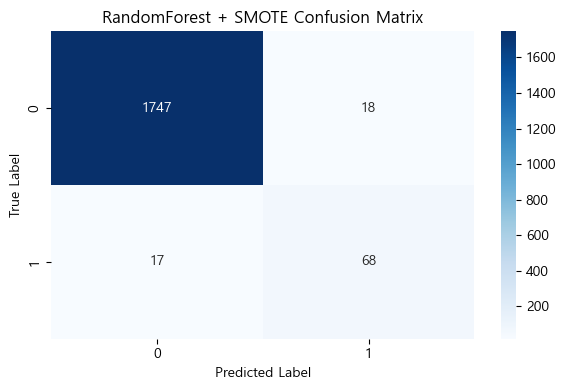

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("RandomForest + SMOTE Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_rf_smote.png")
plt.show()

# ROC Curve 시각화 저장

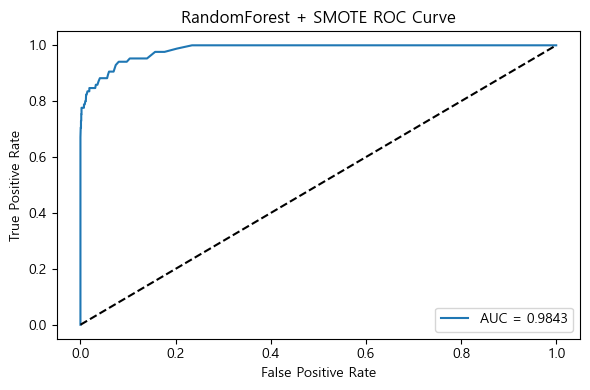

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("RandomForest + SMOTE ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_rf_smote.png")
plt.show()